# Training a FNO on the Shallow Water equations


In [2]:
import time
import sys
import h5py
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, OneCycleLR

# Neural Operator Imports
from neuralop.models import FNO, TFNO
from neuralop import Trainer, LpLoss, H1Loss
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params

# Uncomment the following line if using progress bars
from tqdm.autonotebook import tqdm, trange

#from tabulate import tabulate
import time

## Inital condition: Gauss function

Load data from h5 file.

In [96]:
s = 5

# Initialize empty lists to store the data
h_all = []
u_all = []
time_all = []

# Load the data
for i in range(1, s):
    filename = f'dataFNO/data_sigma_no1mu_no{i}.h5'
    with h5py.File(filename, 'r') as f:

        # Load the dataset (x is the same for all datasets)
        h_all.append(np.real(np.array(f['data_0']['h_all'])))
        u_all.append(np.real(np.array(f['data_0']['u_all'])))
        time_all.append(np.array(f['data_0']['time_all']))
        mesh = np.array(f['data_0']['x'])
        
    print(f'Loaded data from {filename}')
    


Loaded data from dataFNO/data_sigma_no1mu_no1.h5
Loaded data from dataFNO/data_sigma_no1mu_no2.h5
Loaded data from dataFNO/data_sigma_no1mu_no3.h5
Loaded data from dataFNO/data_sigma_no1mu_no4.h5


In [97]:
def prepare_data(h_all, p_train, p_val):

    timesteps, _ = h_all.shape

    # Input a
    a = h_all[:-1]
    a = a[:, np.newaxis, :]

    # Target u (one time step after a)
    u = h_all[1:]
    u = u[:, np.newaxis, :]

    # Split data into training, validation and test sets
    n_train = int(p_train * timesteps)
    n_val = int(p_val * timesteps)
    n_test = timesteps - n_train - n_val

    print(f"n_train = {n_train}, n_val = {n_val}, n_test = {n_test}")

    # Define input and target training sets, validation sets and test sets
    train_x = torch.tensor(a[:n_train], dtype=torch.float32)
    train_y = torch.tensor(u[:n_train], dtype=torch.float32)

    val_x = torch.tensor(a[n_train:n_train + n_val], dtype=torch.float32)
    val_y = torch.tensor(u[n_train:n_train + n_val], dtype=torch.float32)

    test_x = torch.tensor(a[n_train + n_val:], dtype=torch.float32)
    test_y = torch.tensor(u[n_train + n_val:], dtype=torch.float32)

    x = torch.tensor(a, dtype=torch.float32)
    y = torch.tensor(u, dtype=torch.float32)

    #print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

    return n_train, n_val, n_test, x, y, train_x, train_y, val_x, val_y, test_x, test_y


In [116]:
def prepare_combined_data(h_all, p_train_last=0.7, p_val_last=0.15):
    # Initialize lists for training, validation, and test data
    train_x_list, train_y_list = [], []
    val_x_list, val_y_list = [], []
    test_x_list, test_y_list = [], []
    x_list, y_list = [], []

    # Process each case in h_all
    for i, h in enumerate(h_all):
        h_array = np.array(h)  # Convert to NumPy array if necessary
        if i < len(h_all) - 1:  # For the first slices, use 100% training
            n_train, n_val, n_test, x, y, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_array, 1.0, 0.0)
        else:  # For the last case, use specified split proportions
            n_train, n_val, n_test, x, y, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_array, p_train_last, p_val_last)

        # Append results to lists
        train_x_list.append(train_x)
        train_y_list.append(train_y)
        if val_x.shape[0] > 0:  # Only add validation data if it exists
            val_x_list.append(val_x)
            val_y_list.append(val_y)
        if test_x.shape[0] > 0:  # Only add test data if it exists
            test_x_list.append(test_x)
            test_y_list.append(test_y)
        
    # Collect the x and y data for the last case
    x_list.append(x)
    y_list.append(y)
            
    # Concatenate lists into tensors
    train_x_combined = torch.cat(train_x_list, dim=0)
    train_y_combined = torch.cat(train_y_list, dim=0)
    val_x_combined = torch.cat(val_x_list, dim=0) if val_x_list else torch.empty(0)
    val_y_combined = torch.cat(val_y_list, dim=0) if val_y_list else torch.empty(0)
    test_x_combined = torch.cat(test_x_list, dim=0) if test_x_list else torch.empty(0)
    test_y_combined = torch.cat(test_y_list, dim=0) if test_y_list else torch.empty(0)
    x_combined = torch.cat(x_list, dim=0)
    y_combined = torch.cat(y_list, dim=0)

    return n_train, n_val, n_test, train_x_combined, train_y_combined, val_x_combined, val_y_combined, test_x_combined, test_y_combined, x_combined, y_combined

In [117]:
n_train, n_val, n_test, train_x, train_y, val_x, val_y, test_x, test_y, a, u = prepare_combined_data(h_all, p_train_last=0.6, p_val_last=0.2)

print("Training data:", train_x.shape, train_y.shape)
print("Validation data:", val_x.shape, val_y.shape)
print("Test data:", test_x.shape, test_y.shape)


n_train = 731, n_val = 0, n_test = 0
n_train = 712, n_val = 0, n_test = 0
n_train = 695, n_val = 0, n_test = 0
n_train = 407, n_val = 135, n_test = 137
Training data: torch.Size([2542, 1, 200]) torch.Size([2542, 1, 200])
Validation data: torch.Size([135, 1, 200]) torch.Size([135, 1, 200])
Test data: torch.Size([136, 1, 200]) torch.Size([136, 1, 200])


In [100]:
model = TFNO(
    n_modes=(16,), 
    in_channels=1,
    lifting_channels=64, 
    hidden_channels=64, 
    projection_channels=64, 
    out_channels=1, 
    non_linearity=torch.functional.F.relu)

n_params = count_model_params(model)
print(f'\nThe model has {n_params} parameters.')


The model has 308929 parameters.


In [65]:
batch_size = 32

train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

val_dataset = torch.utils.data.TensorDataset(val_x, val_y)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


In [66]:
learn_rate = 1e-3
# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [69]:
loss_train = []
loss_val = []
best_val_loss = np.inf

model.to(device)

# Time training
start_time = time.time()

# Training loop
n_epochs = 10
for epoch in tqdm(range(n_epochs), unit='epoch'):
    model.train()
    epoch_train_loss = 0

    for x, y in dataloader_train:
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate epoch loss
        epoch_train_loss += loss.item() * x.size(0) # loss.item() is the average loss of the batch

    # Validation loss
    model.eval() # Set model to evaluation mode
    epoch_val_loss = 0
    with torch.no_grad(): # Disable gradient tracking
        for x_val, y_val in dataloader_val:
            x_val = y_val.to(device)
            y_val = y_val.to(device)
            val_y_pred = model(x_val)
            val_loss = loss_fn(val_y_pred, y_val)
            epoch_val_loss += val_loss.item() * x_val.size(0) 
            

    # Average losses
    epoch_train_loss /= len(train_dataset)
    epoch_val_loss /= len(val_dataset)

    # Append losses
    loss_train.append(epoch_train_loss)
    loss_val.append(epoch_val_loss)

    # Print epoch loss
    if epoch % 10 == 9:
        print(f'Epoch {epoch + 1}/{n_epochs}: Training loss: {epoch_train_loss:.6f}, Validation loss: {epoch_val_loss:.6f}')


# Time training
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")



  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 10/10: Training loss: 0.000023, Validation loss: 0.000015
Training time: 52.95 seconds


Plot training and validation loss. Iteration = n_epochs x n_batches.

In [70]:
save = 0

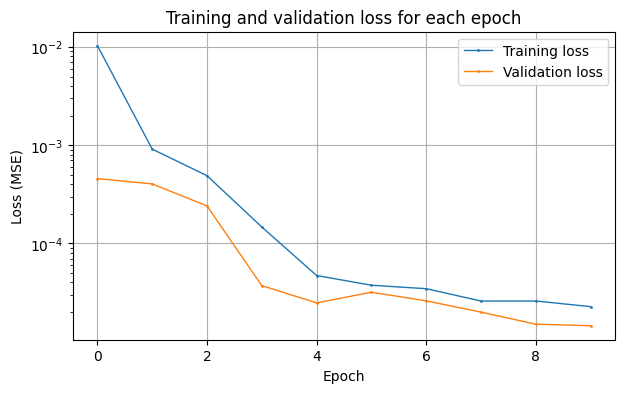

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(loss_train, '.-', label='Training loss', linewidth=1, markersize=2)
plt.plot(loss_val, '.-', label='Validation loss', linewidth=1, markersize=2)
plt.yscale('log')
plt.legend()
plt.grid()
plt.title('Training and validation loss for each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

if save:
    plt.savefig(f'plots/loss_swe_epochs{n_epochs}_channels{model.lifting_channels}_lr_{learn_rate}.pdf', format='pdf')

plt.show()

In [ ]:
# Make predictions
model.eval()
predictions = model(a.to(device)).cpu().detach().numpy()

# Test loss
with torch.no_grad():
    test_loss = loss_fn(model(a), u)
    print(f"Test loss: {test_loss.item():.2e}")

Test loss: 2.15e-05


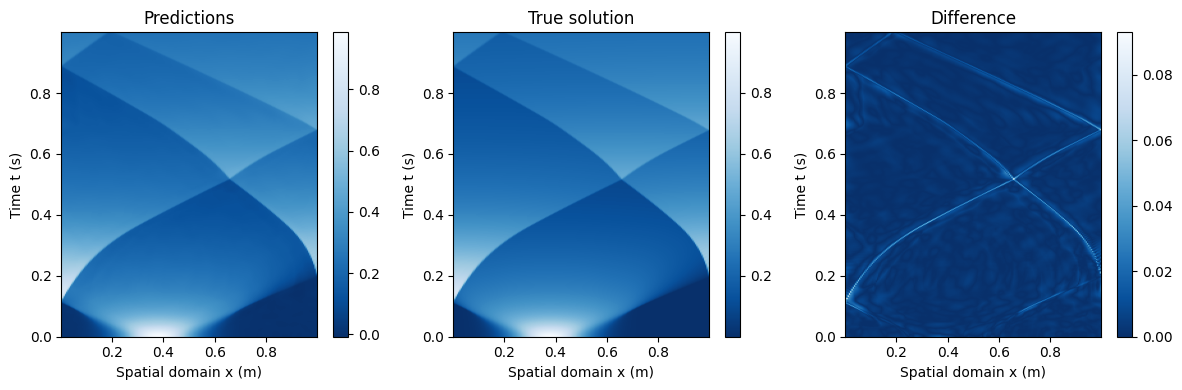

In [101]:
# Assuming x and time_all correspond to the spatial and time dimensions
X, T = np.meshgrid(mesh, time_all[0].squeeze())

cmap = 'Blues_r'

# Plot predictions
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Define the extent based on X and T
extent = [X.min(), X.max(), T.max(), T.min()]  

# Prediction plot
im1 = ax[0].imshow(predictions[:, 0, :], aspect='auto', extent=extent, cmap=cmap)
ax[0].set_title("Predictions")
ax[0].set_xlabel("Spatial domain x (m)")
ax[0].set_ylabel("Time t (s)")
ax[0].invert_yaxis()
plt.colorbar(im1, ax=ax[0])

# True solution plot
im2 = ax[1].imshow(u[:, 0, :], aspect='auto', extent=extent, cmap=cmap)
ax[1].set_title("True solution")
ax[1].set_xlabel("Spatial domain x (m)")
ax[1].set_ylabel("Time t (s)")
ax[1].invert_yaxis()
plt.colorbar(im2, ax=ax[1])

# Difference plot
im3 = ax[2].imshow(np.abs(predictions[:, 0, :] - u[:, 0, :].detach().numpy()), aspect='auto', extent=extent, cmap=cmap)
ax[2].set_title("Difference")
ax[2].set_xlabel("Spatial domain x (m)")
ax[2].set_ylabel("Time t (s)")
ax[2].invert_yaxis()
plt.colorbar(im3, ax=ax[2])

plt.tight_layout()

if save:
    plt.savefig(f'plots/pred_swe_epochs{n_epochs}_channels{model.lifting_channels}_lr_{learn_rate}.pdf', format='pdf')

plt.show()


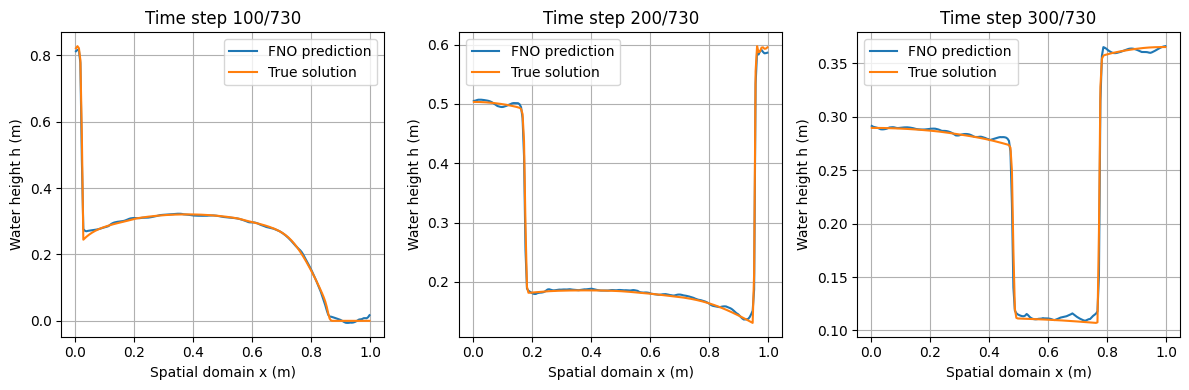

In [ ]:
# Plot for some time steps
indices = [100, 200, 300]

mesh_sq = mesh[0, :]

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(mesh_sq, predictions[indices[0], 0, :], label='FNO prediction')
plt.plot(mesh_sq, u[indices[0], 0, :], label='True solution')
plt.xlabel('Spatial domain x (m)')
plt.ylabel('Water height h (m)')
plt.legend()
plt.grid()
plt.title(f"Time step {indices[0]}/{time_all[0].shape[0]}")

plt.subplot(1, 3, 2)
plt.plot(mesh_sq, predictions[indices[1], 0, :], label='FNO prediction')
plt.plot(mesh_sq, u[indices[1], 0, :], label='True solution')
plt.xlabel('Spatial domain x (m)')
plt.ylabel('Water height h (m)')
plt.legend()
plt.grid()
plt.title(f"Time step {indices[1]}/{time_all[0].shape[0]}")

plt.subplot(1, 3, 3)
plt.plot(mesh_sq, predictions[indices[2], 0, :], label='FNO prediction')
plt.plot(mesh_sq, u[indices[2], 0, :], label='True solution')
plt.xlabel('Spatial domain x (m)')
plt.ylabel('Water height h (m)')
plt.legend()
plt.grid()
plt.title(f"Time step {indices[2]}/{time_all[0].shape[0]}")

plt.tight_layout()

if save:
    plt.savefig(f'plots/pred_swe_epochs{n_epochs}_channels{model.lifting_channels}_lr_{learn_rate}_timesteps.pdf', format='pdf')

plt.show()

(678,)


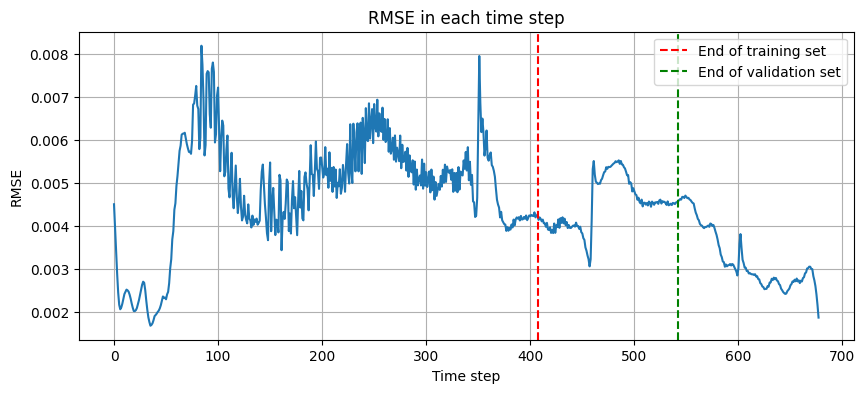

In [119]:
# Plot the RMSE in each time step
rmse = np.sqrt(np.mean((predictions - u.detach().numpy()) ** 2, axis=(1, 2)))
print(rmse.shape)

plt.figure(figsize=(10, 4))
plt.plot(rmse)
plt.axvline(x=n_train, color='r', linestyle='--', label='End of training set')
plt.axvline(x=n_train + n_val, color='g', linestyle='--', label='End of validation set')
plt.xlabel('Time step')
plt.ylabel('RMSE')
plt.title('RMSE in each time step')
plt.legend()
plt.grid()

if save:
    plt.savefig(f'plots/rmse_swe_epochs{n_epochs}_channels{model.lifting_channels}_lr_{learn_rate}.pdf', format='pdf')

plt.show()